##5.2. 합성곱 신경망 맛보기
- fashion_mnist 데이터셋 사용: 토치 비전에 내장된 예제 데이터로, 운동화, 셔츠, 샌들 같은 작은 이미지의 모음

###[1] 필요한 라이브러리 호출

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

- 파이토치는 기본적으로 GPU 사용을 권장하나, GPU가 장착되지 않은 환경에서도 파이토치를 정상적으로 실행하고 사용할 수 있도록 함

###[2] CPU 혹은 GPU 장치 확인

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

###[3] fasion_mnist 데이터셋 내려받기
- 토치비전으로 내려받을 수 있음
- 파라미터
  - 첫번째: 내려받을 위치 지정
  - download = T/f : 다운로드를 해당 위치에 할건지 말건지
  - transform: 이미지를 텐서(0~1)로 변경
  

In [3]:
from google.colab import drive
drive.mount('/content/drive')

train_dataset = torchvision.datasets.FashionMNIST("/content/drive/MyDrive/Colab Notebooks/data", download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST("/content/drive/MyDrive/Colab Notebooks/data", download=False, transform=transforms.Compose([transforms.ToTensor()]))


Mounted at /content/drive


###[4] fashion_mnist 데이터를 데이터 로더에 전달

In [4]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)

- 원하는 크기의 배치 단위로 데이터를 불러오거나 순서가 무작위로 섞이도록 함

###[5] 분류에 사용할 클래스 정의

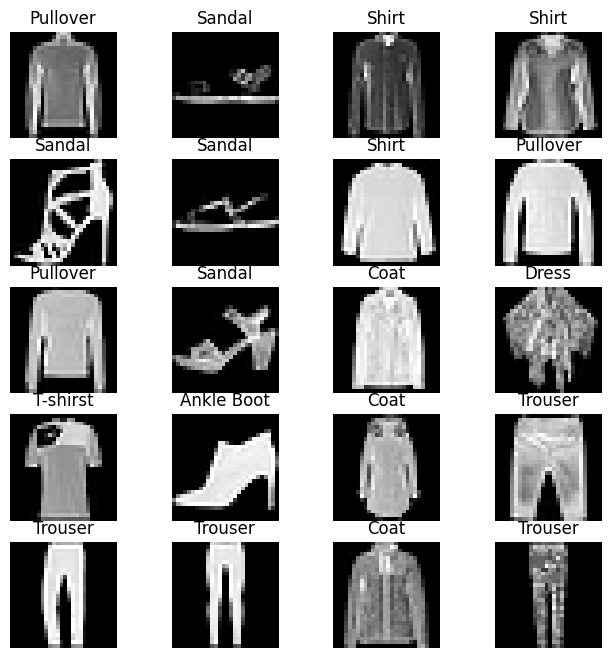

In [5]:
labels_map = {0: 'T-shirst', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle Boot'}

fig = plt.figure(figsize=(8,8));
columns =4;
rows =5;
for i in range(1, columns*rows +1):
  img_xy = np.random.randint(len(train_dataset));
  img = add = train_dataset[img_xy][0][0,:,:]
  fig.add_subplot(rows, columns, i)
  plt.title(labels_map[train_dataset[img_xy][1]])
  plt.axis('off')
  plt.imshow(img, cmap='gray')
plt.show()

- np.random: 무작위로 데이터를 생성할 때 사용
- train_dataset을 이용하여 3차원 배열을 생성함


###[6] 심층 신경망 모델 생성

In [6]:
class FashionDNN(nn.Module):
  def __init__(self):
    super(FashionDNN, self).__init__()
    self.fc1 = nn.Linear(in_features=784, out_features=256)
    self.drop = nn.Dropout(0.25)
    self.fc2 = nn.Linear(in_features=256, out_features=128)
    self.fc3 = nn.Linear(in_features=128, out_features=10)

  def forward(self, input_data):
    out = input_data.view(-1, 784)
    out = F.relu(self.fc1(out))
    out = self.drop(out)
    out = F.relu(self.fc2(out))
    out = self.fc3(out)
    return out

- 클래스 형태의 모델은 항상 torch.nn.Module을 상속 받음
- __init__(): 객체가 갖는 속성 값을 초기화 하는 역할 수행
  - 객체가 생성될 때 자동으로 호출됨
- nn: 딥러닝 모델 구성에 필요한 모듈이 모여있는 패키지
  - Linear: 단순 선형 회귀 모델을 만들 때 사용
- forward(): 모델이 학습 데이터를 입력 받아 순전파 학습을 진행시킴
- view: 넘파이의 reshape와 같은 역할로, 텐서의 크기를 변경해주는 역할을 수행

###[7] 심층 신경망에서 필요한 파라미터 정의
- 손실함수, 학습률, 옵티마이저 정의

In [7]:
learning_rate = 0.001;
model = FashionDNN();
model.to(device)

criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


###[8] 심층 신경망을 이용한 모델 학습

In [8]:
num_epochs = 5
count = 0

loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:

        images = images.to(device)
        labels = labels.to(device)

        train_inputs = images.view(100, 1, 28, 28)

        outputs = model(train_inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        count += 1

        if count % 50 == 0:
            correct = 0
            total = 0

            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)

                labels_list.append(labels)

                test_inputs = images.view(100, 1, 28, 28)
                outputs = model(test_inputs)

                predictions = torch.max(outputs, 1)[1]
                predictions_list.append(predictions)

                correct += (predictions == labels).sum().item()
                total += labels.size(0)

            accuracy = correct * 100 / total

            loss_list.append(loss.item())
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if count % 500 == 0:
            print(f"Iteration: {count}, Loss: {loss.item()}, Accuracy: {accuracy}%")


Iteration: 500, Loss: 0.5501694679260254, Accuracy: 84.37666666666667%
Iteration: 1000, Loss: 0.4652566611766815, Accuracy: 85.78666666666666%
Iteration: 1500, Loss: 0.3648170232772827, Accuracy: 85.9%
Iteration: 2000, Loss: 0.39225828647613525, Accuracy: 87.25833333333334%
Iteration: 2500, Loss: 0.2424902319908142, Accuracy: 88.06%
Iteration: 3000, Loss: 0.2727281153202057, Accuracy: 88.35666666666667%


- 정확도가 88%로 높음을 확인 가능

###[9] 합성곱 네트워크 생성

In [9]:
class FashionCNN(nn.Module):
  def __init__(self):
    super(FashionCNN, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
    self.drop = nn.Dropout2d(0.25)
    self.fc2 = nn.Linear(in_features=600, out_features=120)
    self.fc3 = nn.Linear(in_features=120, out_features=10)

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    out = self.drop(out)
    out = self.fc2(out)
    out = self.fc3(out)
    return out

- nn.Sequential: __init__()에서 사용할 네트워크 모델들을 정의 + forward() 함수에서 구현되는 순전파를 계층 형태로 가독성 있게 작성 가능
- 합성곱층: 합성곱 연산을 통해 이미지 특징을 추출
  - 커널이라는 n*m 크기의 행렬이 높이, 너미 크기의 이미지를 처음부터 끝까지 훑으면서 각 원소 값끼리 곲한 후 모두 더한 값을 출력함
  - in_channels: 입력 채널의 수
    - 흑백: 1
    - RGB: 3
  - BatchNorm2d: 학습 과정에서 각 배치 단위별로 데이터가 다양한 분포를 가지더라도 평균과 분산을 이용해 정규화 하려는것
    - 분포를 가우시안 형태로 만들어 평균 0, 분산 1로 만듦
  - Conv2d:이미지의 데이터를 배열 형태로 변환하여 작업할 때 하이퍼 파라미터 값에 따라 출력크기가 달라짐 -> 완전 연결층으로 전달

###[10] 합성곱 네트워크를 사용하기 위한 파라미터 정의

In [10]:
learning_rate = 0.001;
model = FashionCNN();
model.to(device)

criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


###[11] 모델 학습 및 성능 평가

In [11]:
num_epochs = 5
count = 0

loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:

        images = images.to(device)
        labels = labels.to(device)

        train = images
        labels = labels

        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if count % 50 == 0:
            correct = 0
            total = 0

            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)

                test = images
                outputs = model(test)

                predictions = torch.max(outputs, 1)[1]
                correct += (predictions == labels).sum()
                total += labels.size(0)

            accuracy = correct.float() * 100 / total
            loss_list.append(loss.item())
            iteration_list.append(count)
            accuracy_list.append(accuracy.item())

        if count % 500 == 0:
            print(f"Iteration: {count}, Loss: {loss.item()}, Accuracy: {accuracy.item()}%")


/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:1535: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500, Loss: 0.45188766717910767, Accuracy: 88.66333770751953%
Iteration: 1000, Loss: 0.3247217535972595, Accuracy: 88.01166534423828%
Iteration: 1500, Loss: 0.3355850875377655, Accuracy: 89.69166564941406%
Iteration: 2000, Loss: 0.2651623487472534, Accuracy: 90.75833129882812%
Iteration: 2500, Loss: 0.19270741939544678, Accuracy: 92.83333587646484%
Iteration: 3000, Loss: 0.160690575838089, Accuracy: 93.02166748046875%
